# Tourmaline R Notebook

This R notebook will work "out of the box" with the test data included with Tourmaline. To run with your own data, just make sure to change the variables in the section **Define variables** to match your metadata and desired parameters.

This R notebook presents an example of importing and visualizing Tourmaline output files (data and taxonomy files) in R and uses common R packages for visualizing amplicon sequencing data (e.g. phyloseq; McMurdie and Holmes 2013). 

The test dataset contains samples that were collected from Western Lake Erie in 2018. This example workflow uses a subset of the 16S samples and includes code on how to import QIIME 2 .qza files into R and build plots of alpha and beta diversity and 16S taxonomy bar plots using packages like phyloseq and ggplot2. For this example dataset, samples will be partitioned based on filter size of collected DNA (0.22 vs. 5 um) and sampling region (Western Boundary vs. Open Water).

## Install packages (first time only)

Open up a bash terminal window, and create a new R environment, installing base R and essential packages, including the R Jupyter kernel (IRKernel), then activate the environment:

In [ ]:
conda create -n r-latest r-essentials r-base
conda activate r-latest

To install the R packages, type `R` or `r` to start an R session within your conda environment, then enter these commands to install the packages (select "All" if asked to update packages):

In [ ]:
install.packages("devtools")
library("devtools")
install_github("joey711/phyloseq")

In [ ]:
install.packages("remotes")
remotes::install_github("jbisanz/qiime2R")

In [ ]:
install.packages("tidyverse")
install.packages("RColorBrewer")
install.packages("vegan")

## Load packages

Load R packages needed for this workflow:

In [1]:
library(qiime2R)
library(phyloseq)
library(tidyverse)
library(RColorBrewer)
library(vegan)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



## Define variables

In [2]:
method = "dada2-pe"
filtering = "unfiltered"
adiv_metric = "Shannon"
bdiv_metric = "bray"
factor1 = "region"
factor2 = "filter_size"
factor3 = "sample_name"

## Read DataFrames

To explore amplicon data in R, we use the qiime2R package, which in this case, loads QIIME 2 artifact files (.qza files) from Tourmaline output into R. For this workflow, only the taxonomy and count table are loaded, though other .qza files produced from Tourmaline (e.g. phylogenetic trees or representative sequences files) can be loaded using the same approach. Note, the read_qza function in qiime2R requires the user to specify the file path which corresponds to the location of the Tourmaline output files.

### Representative sequences and observation table -- NEED TO INSERT VARIABLES IN FILEPATHS

In [3]:
count_table <- read_qza(file=sprintf("../02-output-%s-%s/00-table-repseqs/table.qza", method, filtering))
count_table <- count_table$data
tax_table <- read_qza(file=sprintf("../02-output-%s-%s/01-taxonomy/taxonomy.qza", method, filtering))
tax_table <- tax_table$data %>% 
as_tibble() %>% 
separate(Taxon, sep=";", c("Rank1", "Rank2", "Rank3", "Rank4", "Rank5", "Rank6", "Rank7")) # Taxa levels can be changed accordingly

Warning message:
“Expected 7 pieces. Additional pieces discarded in 2 rows [1, 2].”
Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 299 rows [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, ...].”


### Metadata

Upload sample metadata file used in the Tourmaline run. The metadata .tsv file will be in the 00-data subfolder.

In [4]:
metadata_table <- read_tsv(file="../00-data/metadata.tsv")
metadata_table  <- sample_data(metadata_table)
rownames(metadata_table ) <- metadata_table$sample_name


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  sample_pairs = col_double(),
  auv_latitude_deg = col_double(),
  auv_longitude_deg = col_double(),
  archive_bottom = col_double(),
  `puck_no_7-0xxx` = col_double(),
  time_started_filtering = col_time(format = ""),
  filtration_duration_hhmmss = col_time(format = ""),
  auv_avg_sample_depth_m = col_double(),
  auv_range_sample_depth_m = col_double(),
  auv_sample_volume = col_double(),
  auv_chlorophyll_mean_ug_per_l = col_double(),
  auv_oxygen_mean_ug_per_l = col_double(),
  auv_par_mean_umol_s_m2 = col_double(),
  auv_temp_mean_degc = col_double(),
  qpcr_16s_total_cyano_cpr = col_double(),
  total_cyanobacteria_qpcr_gc_per_ml = col_double(),
  qpcr_toxin_mcye_cpr = col_double(),
  mcye_qpcr_gc_per_ml = col_double(),
  sample_potency = col_double(),
  sample_number_16s = col_double()
  # ... with 4 more columns
)
ℹ Use 

### Merge into phyloseq object

Merge everything together into a phyloseq object. The phyloseq object will have the taxonomy, count, and metadata files all included, allowing for easy subsetting of the data or plotting based on factors in the metadata (in this case by sampling region or DNA filter size). Rarefy data to the minimum read count. 

In [5]:
physeq <- phyloseq(otu_table(count_table, taxa_are_rows= T), tax_table(as.data.frame(tax_table) %>% column_to_rownames("Feature.ID") %>% as.matrix()), sample_data(metadata_table))

suppressMessages(physeq_rarefy <- rarefy_even_depth(physeq, sample.size = min(sample_sums(physeq)), rngseed = 714, replace = TRUE, trimOTUs = TRUE))

## Set factors and plotting parameters

Define factors (from metadata, defined above) and plotting parameters used to make diversity and taxonomy bar plots:

In [6]:
# Set factors
Factor1 = get(factor1, sample_data(physeq_rarefy))
Factor2 = get(factor2, sample_data(physeq_rarefy))
Factor3 = get(factor3, sample_data(physeq_rarefy))

# Set plotting parameters
theme = theme_bw()
point = geom_point(size = 5)
shape = scale_shape_manual(values = c(21, 24))
boxplot = geom_boxplot(lwd = 1)
color = scale_fill_brewer(palette="Dark2") 
bar_color = scale_fill_brewer(palette="Paired") 
stacked_bar = geom_bar(stat="identity", position = "fill")
bar_yaxis = scale_y_continuous(expand = c(0, 0), breaks=seq(0,1,0.2), limits=c(0, 1)) 
y_intercept = geom_hline(yintercept=0)
legend_pos = theme(legend.position="bottom")
legend_row = guides(fill=guide_legend(nrow=2)) 
plot_image = options(repr.plot.width=8, repr.plot.height=5)

## Create plots

Estimate and plot alpha diversity values for 16S samples, coloring by region and faceting plots by filter size using predefined factors. Faceting allows the user to more clearly visualize differences in the data between variables of interest.

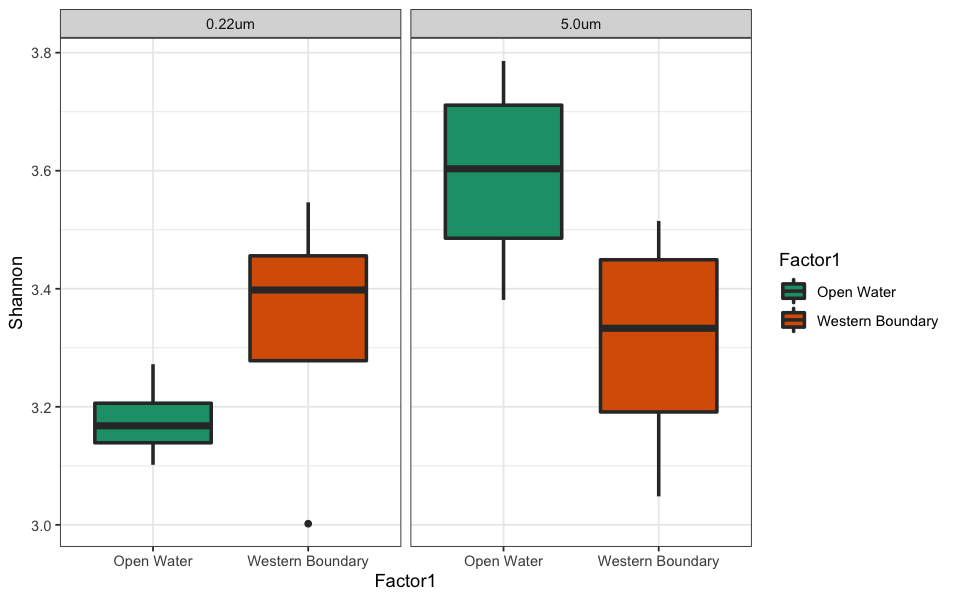

In [7]:
# Estimate richness
alpha <- estimate_richness(
  physeq = physeq_rarefy,
  measures=c(adiv_metric)) %>%
  cbind(Factor1, Factor2)

# Plot
ggplot(data=alpha, aes(x=Factor1, y=Shannon, fill=Factor1)) + theme +
boxplot + color + facet_grid(~ Factor2)                             

Run and plot an NMDS ordination on the 16S test data. Sample counts are transformed to relative abundance. Samples are colored by region using the same color palette and have symbols that are shaped according to filter size. 

Run 0 stress 0.08034733 
Run 1 stress 0.1490501 
Run 2 stress 0.08034737 
... Procrustes: rmse 6.046996e-05  max resid 0.0001423998 
... Similar to previous best
Run 3 stress 0.08528066 
Run 4 stress 0.08528065 
Run 5 stress 0.08034733 
... New best solution
... Procrustes: rmse 3.747012e-06  max resid 7.307358e-06 
... Similar to previous best
Run 6 stress 0.08528065 
Run 7 stress 0.08528075 
Run 8 stress 0.1668095 
Run 9 stress 0.08528065 
Run 10 stress 0.08528065 
Run 11 stress 0.1658009 
Run 12 stress 0.1809766 
Run 13 stress 0.08528065 
Run 14 stress 0.08528066 
Run 15 stress 0.08528065 
Run 16 stress 0.08528065 
Run 17 stress 0.2194629 
Run 18 stress 0.08528065 
Run 19 stress 0.08034733 
... Procrustes: rmse 5.18529e-06  max resid 1.129659e-05 
... Similar to previous best
Run 20 stress 0.221314 
*** Solution reached


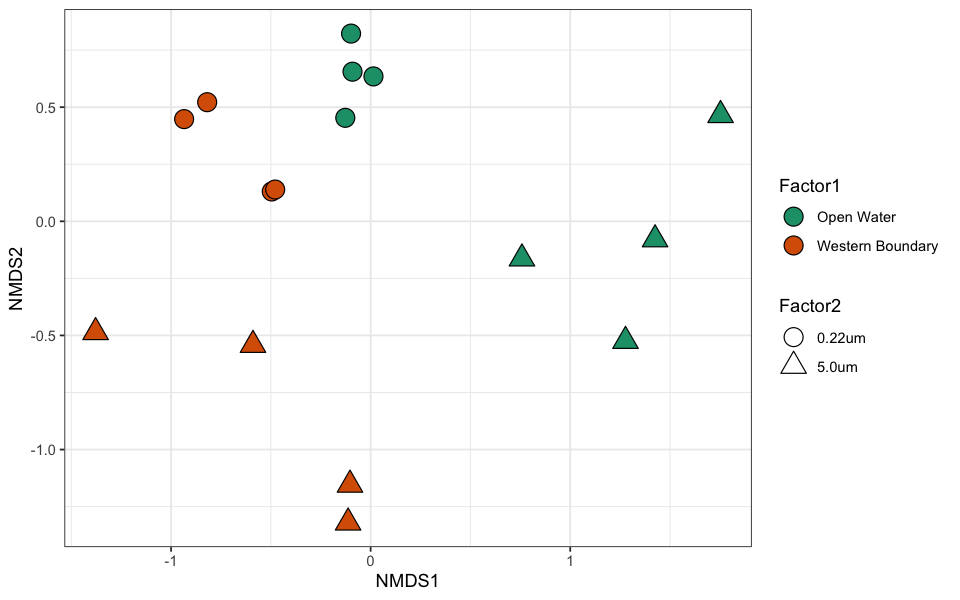

In [8]:
# Transform data
physeq_rel <- physeq_rarefy %>%
  transform_sample_counts(function(x) {x/sum(x)} )                                      
   
# Ordinate
nmds <- ordinate(
  physeq = physeq_rel, 
  method = "NMDS", 
  distance = bdiv_metric) %>%
  scores() %>%
  as.data.frame() %>%
  cbind(Factor1, Factor2)
  
# Plot 
ggplot(data=nmds, aes(x=NMDS1, y=NMDS2, fill=Factor1, shape=Factor2)) + theme +
color + point + shape + guides(fill=guide_legend(override.aes=list(shape=21)))                                                 

Plot stacked taxa bar plots of the top 16S taxa groups at the class level (similar approach used for any other taxa level). Low abundant taxa (< 5%) are filtered out. Samples are faceted based on the sampling region in Lake Erie and are labeled on x-axis according to sample name and filter size. 

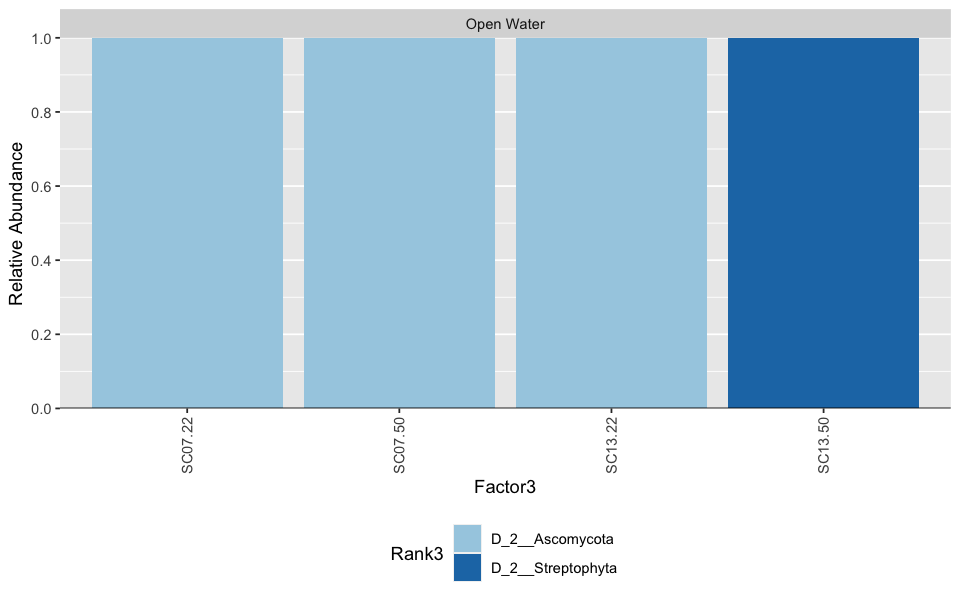

In [13]:
# Prepare phyloseq data for bar plots
barplot <- physeq_rarefy %>%
   tax_glom(taxrank = "Rank3") %>%                      # Agglomerate at class level, which is Rank3 in this case
   transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
   psmelt() %>%                                         # Melt to long format
   cbind(Factor1, Factor2, Factor3) %>% 
   filter(Abundance > 0.05) %>%                         # Filter out low abundance taxa
   arrange(Rank3)               
 
# Plot
ggplot(barplot, aes(x=Factor3, y=Abundance, fill=Rank3)) +
stacked_bar + bar_yaxis + y_intercept + bar_color + legend_pos +
legend_row + labs(y = "Relative Abundance") + facet_grid(~ Factor1, scales = "free_x") + theme(axis.text.x=element_text(angle=90,vjust=0.5))